In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import math

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f'Device is: {device}')

!nvidia-smi

Device is: cuda
Thu Mar 11 11:41:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                        

(500, 8, 24, 1)
(500, 24, 1)


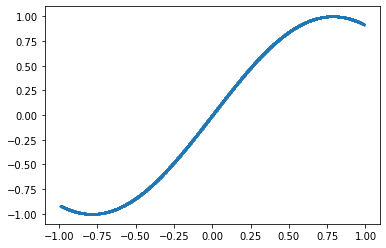

In [3]:
# Data set has to have shape N_batches x seq_len x batch_size x N_in
batch_size = 24
N_batches = 500
seq_len = 8
N_in = 1

x = np.array([[[[i + j + k + 2*n for i in range(N_in)] for j in range(batch_size)] for k in range(seq_len)] for n in range(N_batches)])
print(x.shape)

x = 2 * (x - np.mean(x))/np.max(x)

#y = np.mean(x, axis=1)
#y = np.mean(x, axis=1) * np.mean(x, axis=1)
y = np.sin(2*np.mean(x, axis=1))
print(y.shape)

plt.scatter(np.mean(x, axis=1).flatten(), y.flatten(), s = 1)

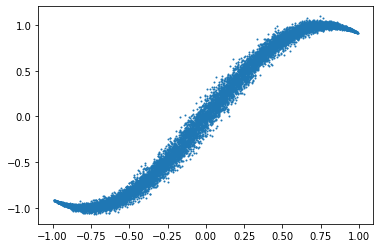

In [4]:
# Add noise
from numpy.random import default_rng

rng = default_rng(1)

#std_dev = 0.1 * np.abs(np.mean(x, axis=1)).flatten()
std_dev = 0.1 * (1 - np.abs(np.mean(x, axis=1))).flatten()
variance = std_dev**2
noise = rng.normal(np.zeros(N_batches * batch_size), std_dev)

y = y + noise.reshape(N_batches, batch_size, 1)

plt.scatter(np.mean(x, axis=1).flatten(), y.flatten(), s = 1)

In [5]:
#Shuffle data
np.random.seed(0)
torch.manual_seed(0)

X_ordered = x
y_ordered = y
inds = np.random.permutation(np.arange(N_batches))
X = X_ordered[inds]
y = y_ordered[inds]

In [6]:
#Split data
N_train = int(0.8 * N_batches)

X_train = X[:N_train]
y_train = y[:N_train]
X_train = torch.from_numpy(X_train).double().to(device)
y_train = torch.from_numpy(y_train).double().to(device)

print("Train X and y")
print(X_train.shape, y_train.shape)

#Set test data set
X_test = X[N_train:]
y_test = y[N_train:]
X_test = torch.from_numpy(X_test).double().to(device)
y_test = torch.from_numpy(y_test).double().to(device)


print("Test X and y")
print(X_test.shape, y_test.shape)

Train X and y
torch.Size([400, 8, 24, 1]) torch.Size([400, 24, 1])
Test X and y
torch.Size([100, 8, 24, 1]) torch.Size([100, 24, 1])


Gaussian negative log-likelihood loss

In [7]:
def gaussian_nll_loss(input, target, var, *, full=False, eps=1e-6, reduction='mean'):
    r"""Gaussian negative log likelihood loss.
    See :class:`~torch.nn.GaussianNLLLoss` for details.
    Args:
        input: expectation of the Gaussian distribution.
        target: sample from the Gaussian distribution.
        var: tensor of positive variance(s), one for each of the expectations
            in the input (heteroscedastic), or a single one (homoscedastic).
        full: ``True``/``False`` (bool), include the constant term in the loss
            calculation. Default: ``False``.
        eps: value added to var, for stability. Default: 1e-6.
        reduction: specifies the reduction to apply to the output:
            `'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the output is the average of all batch member losses,
            ``'sum'``: the output is the sum of all batch member losses.
            Default: ``'mean'``.
    """

    # Inputs and targets much have same shape
    input = input.view(input.size(0), -1)
    target = target.view(target.size(0), -1)
    if input.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of var must match that of input or be equal to 1
    var = var.view(input.size(0), -1)
    if var.size(1) != input.size(1) and var.size(1) != 1:
        raise ValueError("var is of incorrect size")

    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(var < 0):
        raise ValueError("var has negative entry/entries")

    # Clamp for stability
    var = var.clone()
    with torch.no_grad():
        var.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = 0.5 * (torch.log(var) + (input - target)**2 / var).view(input.size(0), -1).sum(dim=1)

    # Add constant to loss term if required
    if full:
        D = input.size(1)
        loss = loss + 0.5 * D * math.log(2 * math.pi)

    # Apply reduction
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

In [8]:
#LSTM on toy data
N_lay = 2
N_out = 2

#Init the net
net = torch.nn.LSTM(N_in, N_out, N_lay).double().to(device)
print(net)

LSTM(1, 2, num_layers=2)


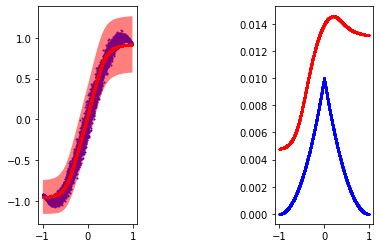

0 -0.8739937283348165


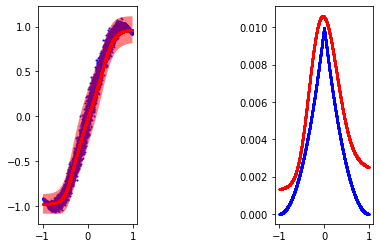

1 -2.039989656124111


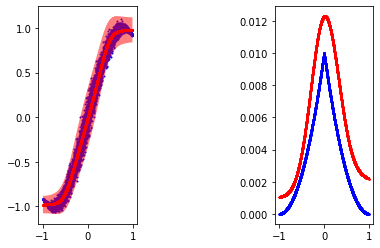

2 -2.1622242388654227


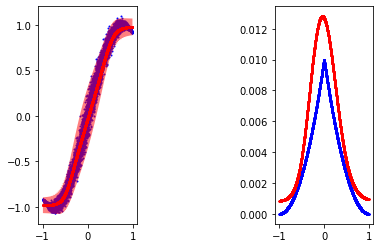

3 -2.3308160789139674


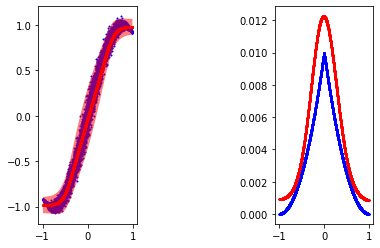

4 -2.299709166803642


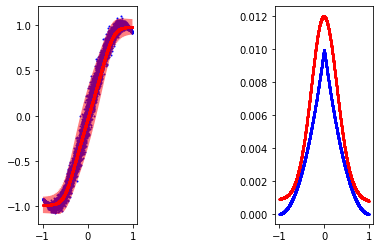

5 -2.3207481986201306


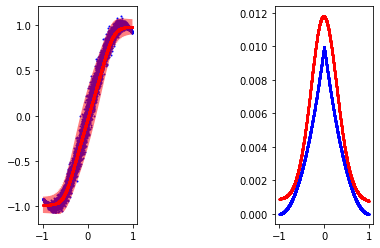

6 -2.334096547153469


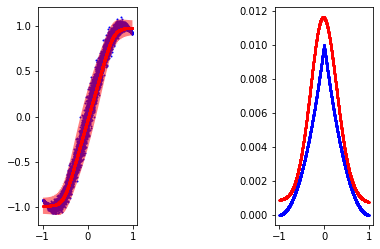

7 -2.341273628324797


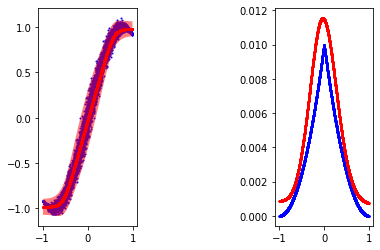

8 -2.3479217937075143


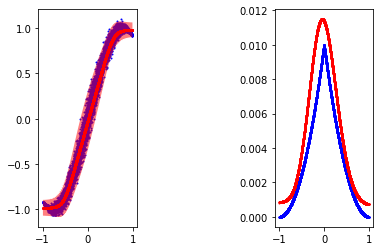

9 -2.355784645113695


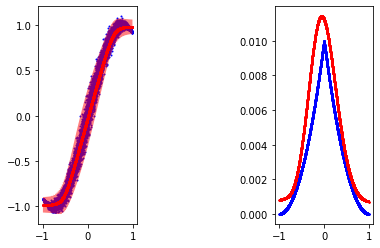

10 -2.365280608054604


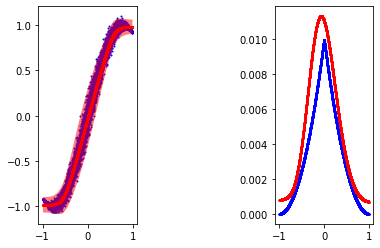

11 -2.375517957387376


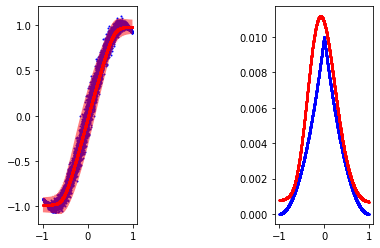

12 -2.385590629762014


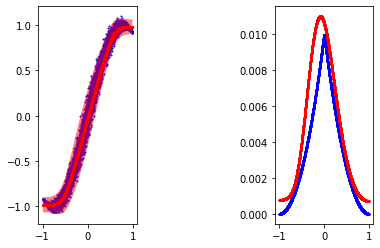

13 -2.3948680855655082


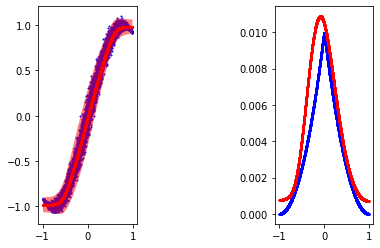

14 -2.402538738077068


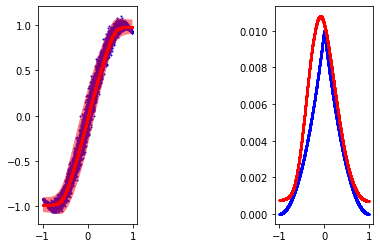

15 -2.4080858542930845


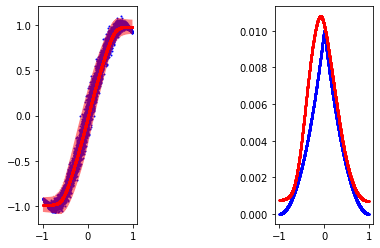

16 -2.411828550020812


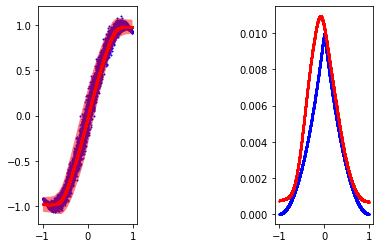

17 -2.4143039162115785


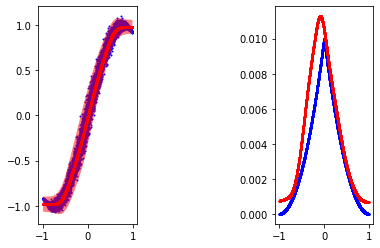

18 -2.4161072359478104


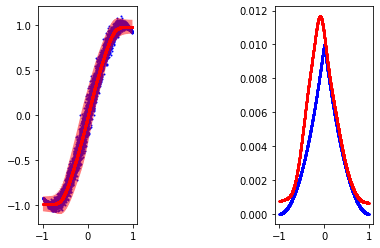

19 -2.4182967844858676


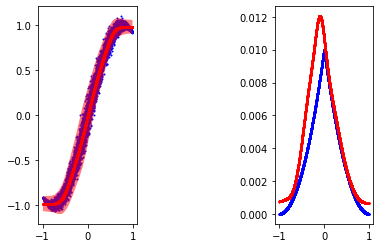

20 -2.4210539199284655


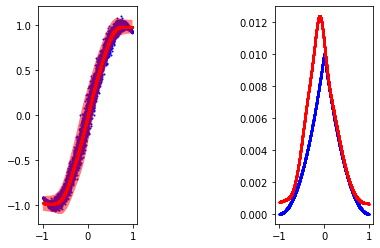

21 -2.424380664587177


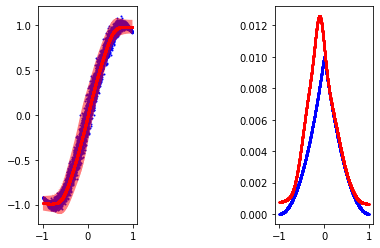

22 -2.4285197880132112


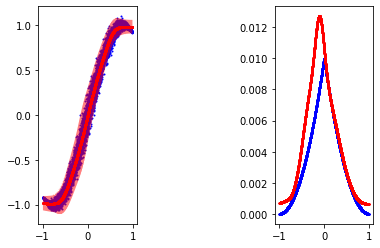

23 -2.4335935958995614


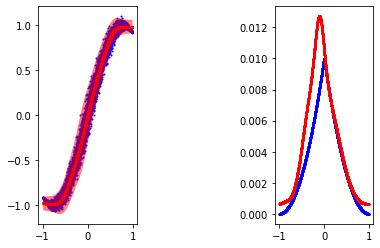

24 -2.4392506274965635


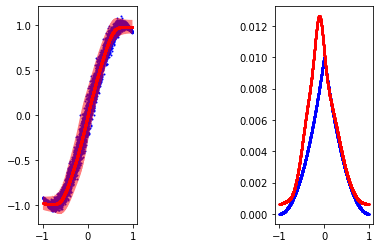

25 -2.4452681569968218


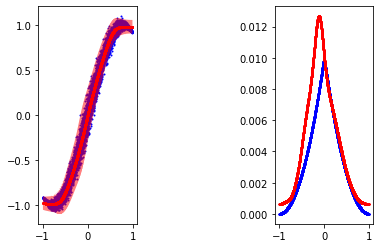

26 -2.449934335244731


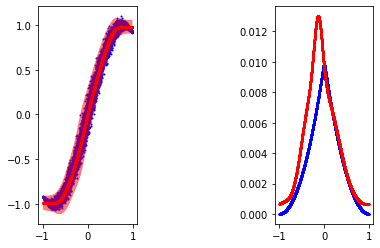

27 -2.4487476469172993


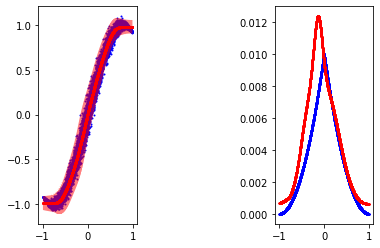

28 -2.446703074509622


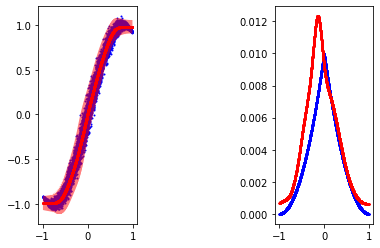

29 -2.448692030600914


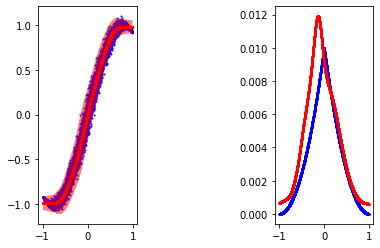

30 -2.44702021571601


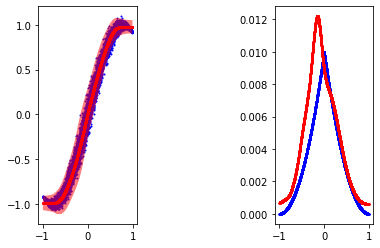

31 -2.4509325473478234


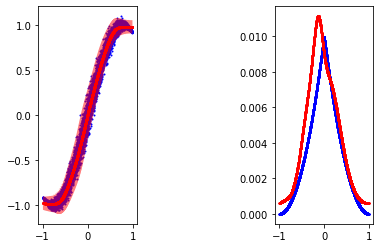

32 -2.447528758315209


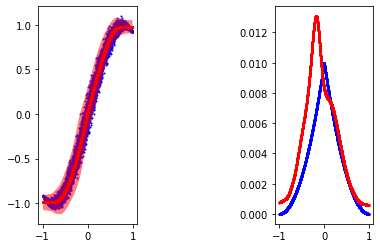

33 -2.452221587455905


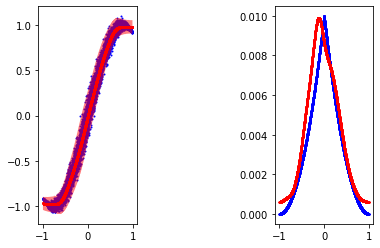

34 -2.4496856890800167


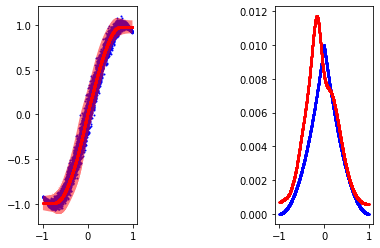

35 -2.459208909747525


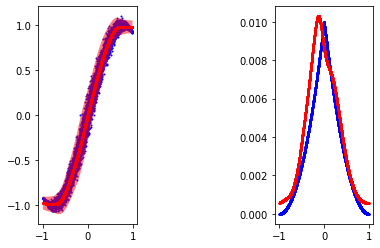

36 -2.456668140721222


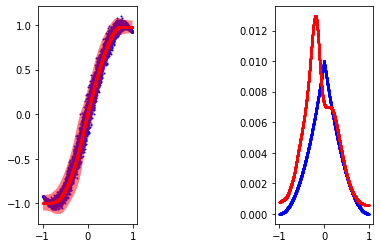

37 -2.4575966035960177


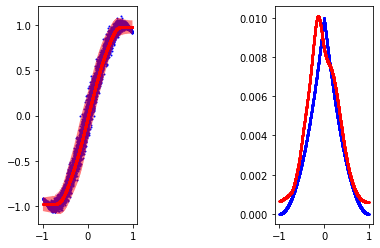

38 -2.450005894082395


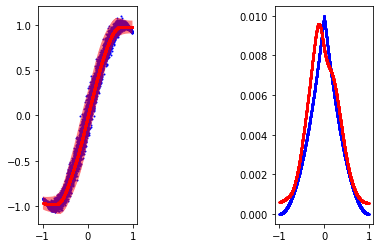

39 -2.4646463976162205


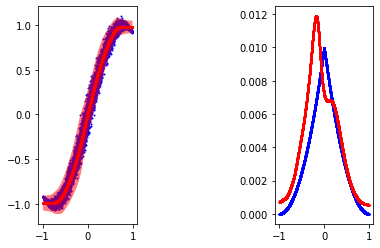

40 -2.466553171736204


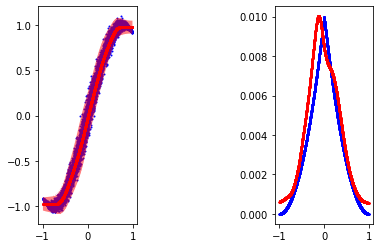

41 -2.45953931815184


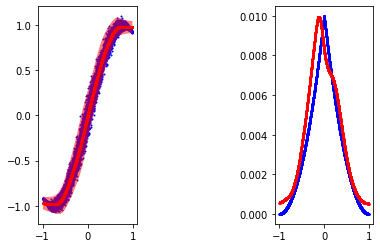

42 -2.4723425612705183


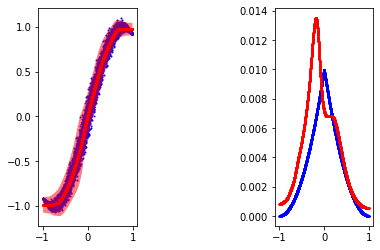

43 -2.466059595006493


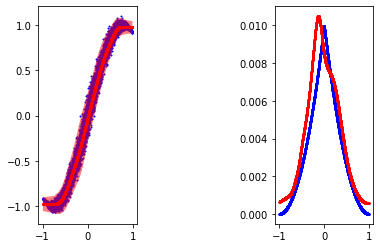

44 -2.4586208394226947


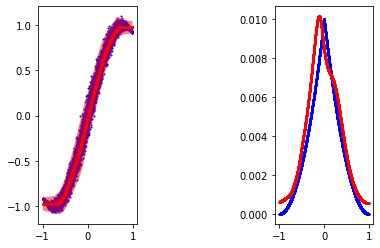

45 -2.472450267448984


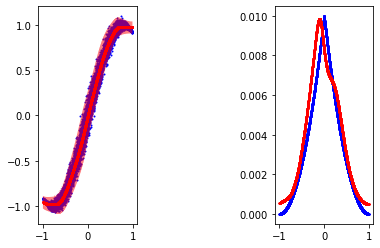

46 -2.4796558911974698


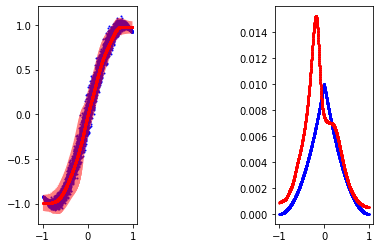

47 -2.4695803191812744


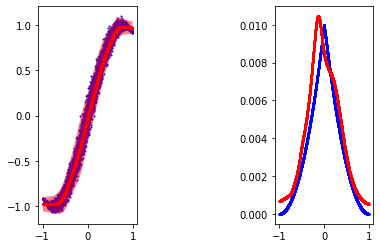

48 -2.4618709381838313


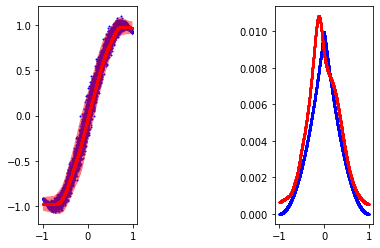

49 -2.477204414742646


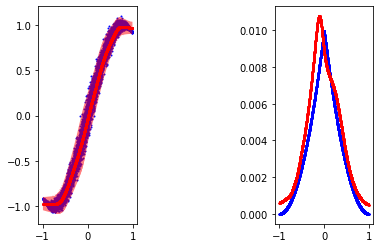

50 -2.482017299004718


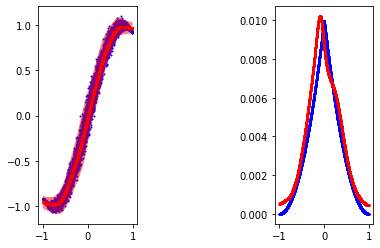

51 -2.489564834355409


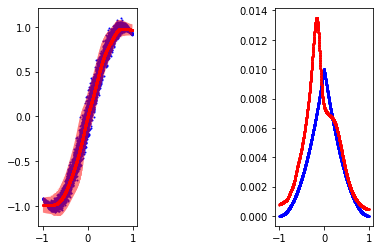

52 -2.4807699765137747


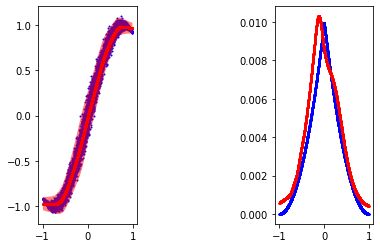

53 -2.4726813220926527


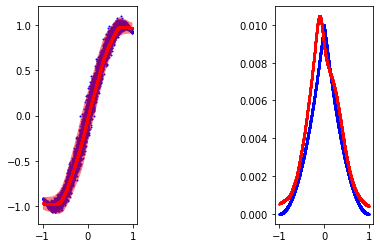

54 -2.494016762814903


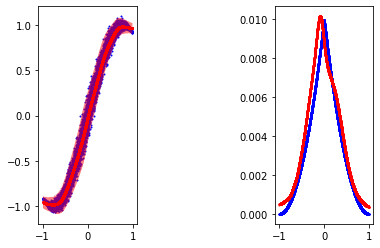

55 -2.5010630772743503


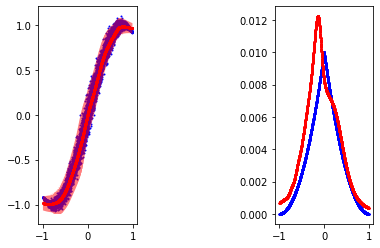

56 -2.4955334677863856


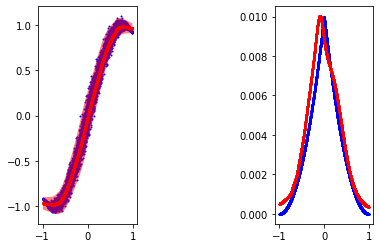

57 -2.4924350523771563


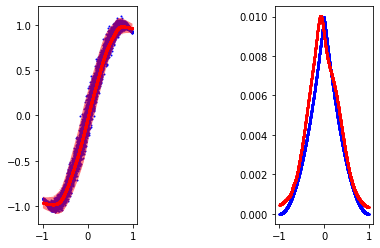

58 -2.511154982637849


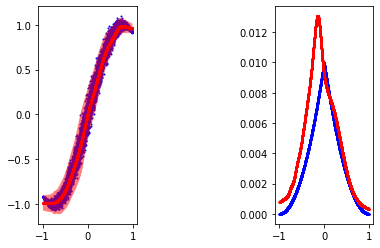

59 -2.497057621780925


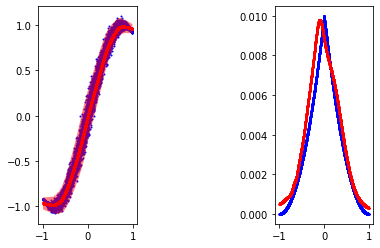

60 -2.4855956944604696


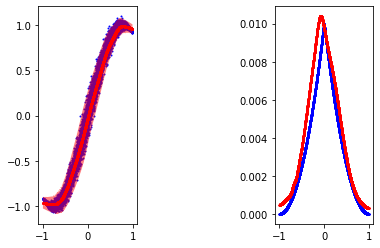

61 -2.519147783824812


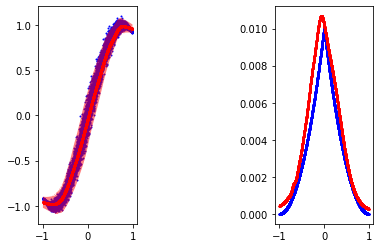

62 -2.524498479789533


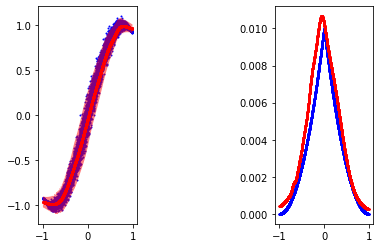

63 -2.5294621417450425


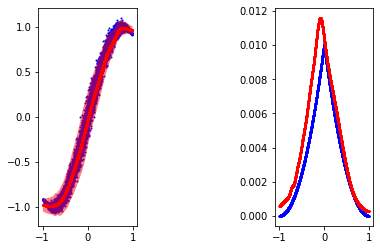

64 -2.5250013787377488


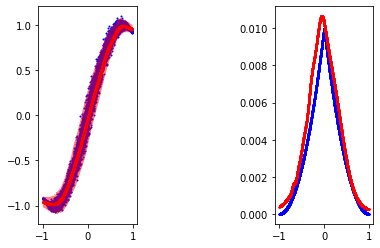

65 -2.5234804101240202


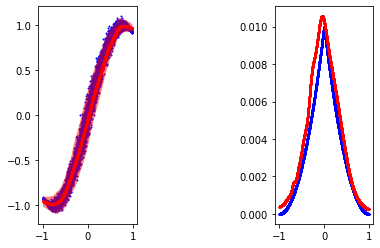

66 -2.537168589903042


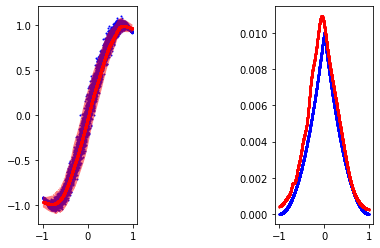

67 -2.5382524818012557


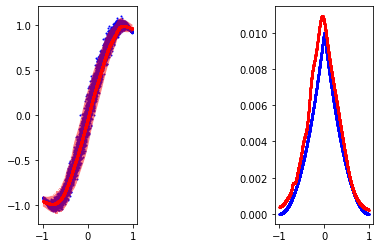

68 -2.5424254244017455


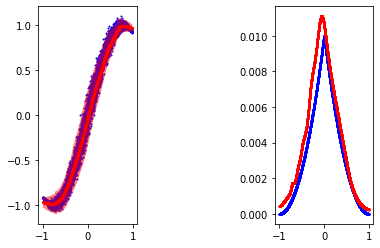

69 -2.540570199303609


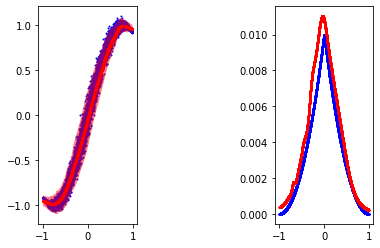

70 -2.5456163534814586


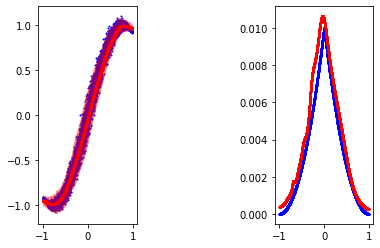

71 -2.5475025462171814


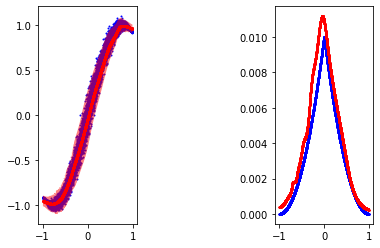

72 -2.549653299674039


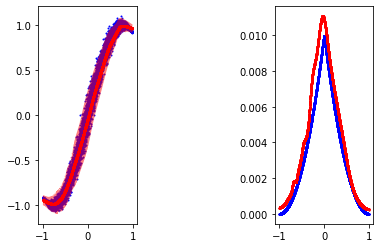

73 -2.553619063925418


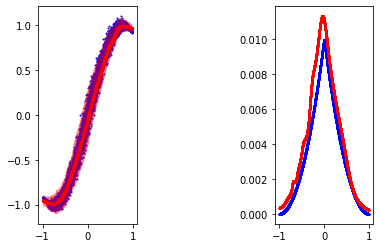

74 -2.553891728892444


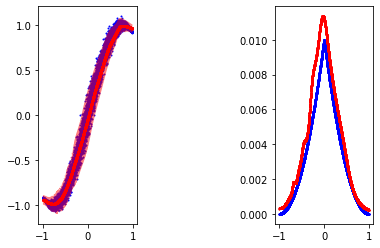

75 -2.558813725378415


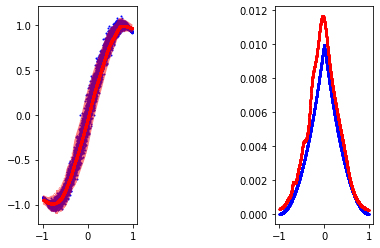

76 -2.559917239091072


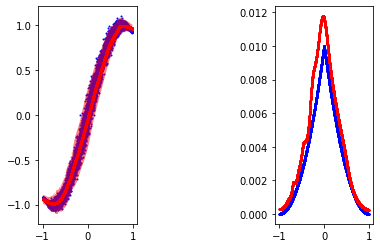

77 -2.563323272258551


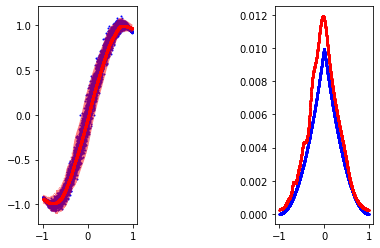

78 -2.5647302679682826


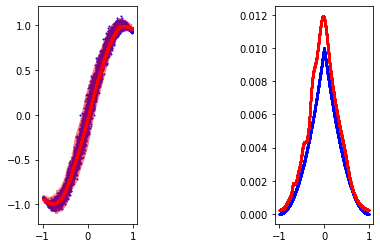

79 -2.5664200519843146


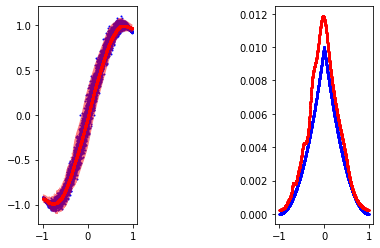

80 -2.567928868850602


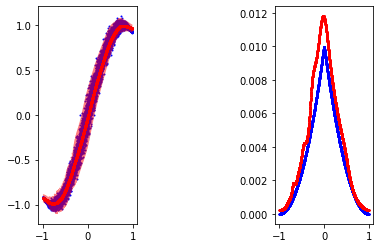

81 -2.569468279036213


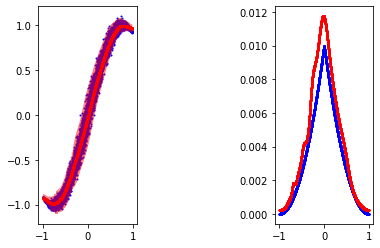

82 -2.570792825697108


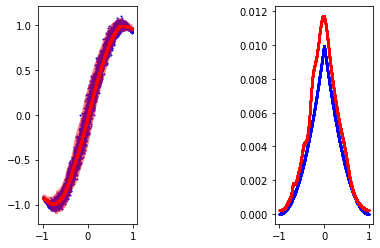

83 -2.571948718311187


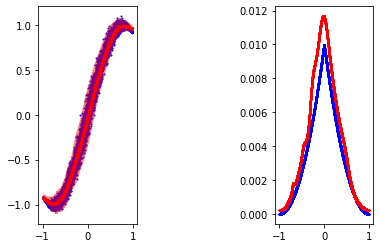

84 -2.5728697380340844


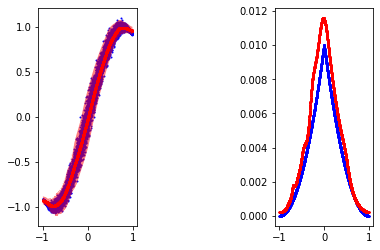

85 -2.573899435565108


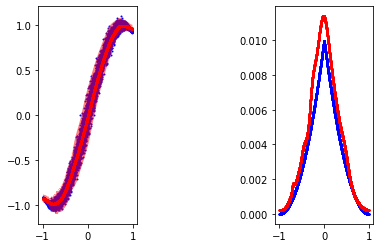

86 -2.5748475915933478


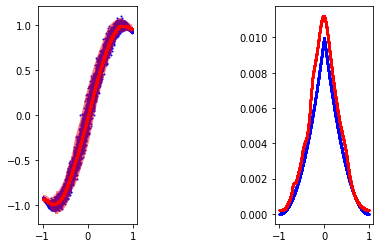

87 -2.5755351666189523


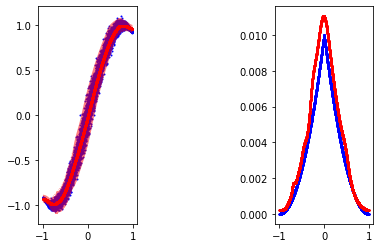

88 -2.5760752008681953


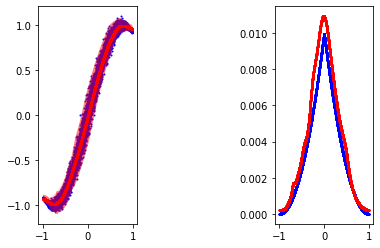

89 -2.576748931547327


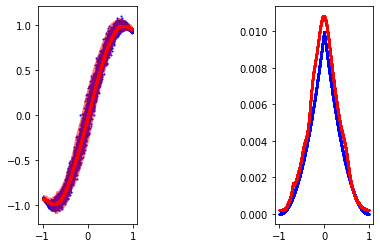

90 -2.5774585209204948


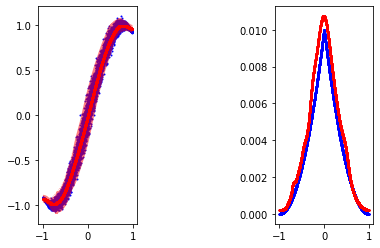

91 -2.578187271523455


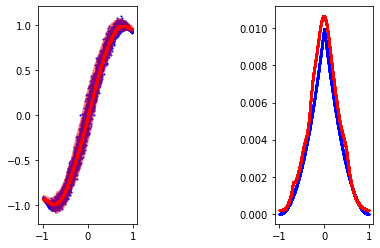

92 -2.5789109700326533


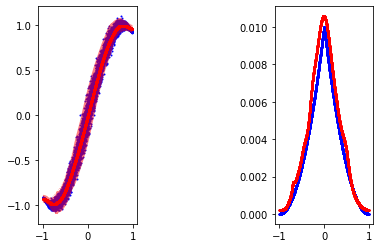

93 -2.5796466828861093


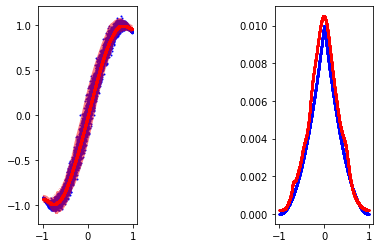

94 -2.5803742138731427


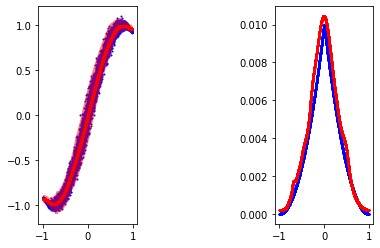

95 -2.5811013623871015


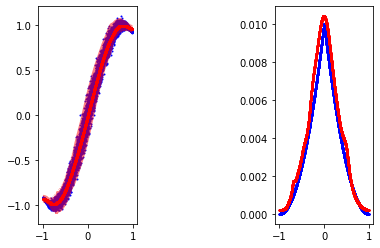

96 -2.5818191148105814


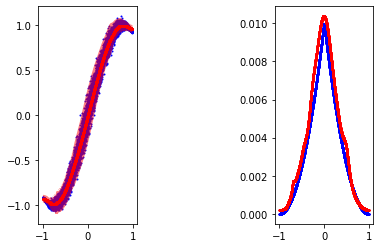

97 -2.5825313587652956


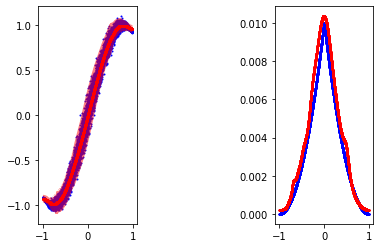

98 -2.583236881507946


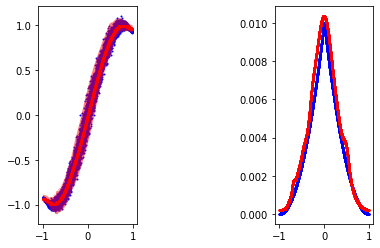

99 -2.5839367220276817


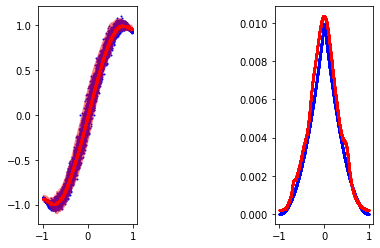

100 -2.5846336471967755


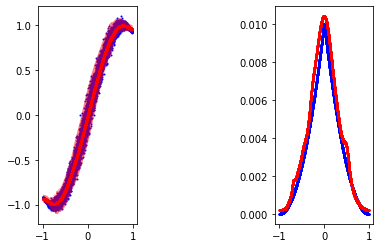

101 -2.5853266416681193


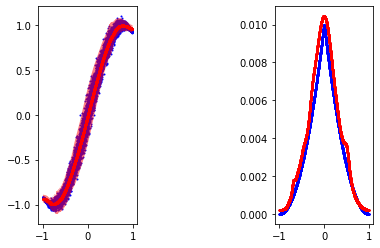

102 -2.5860194593966246


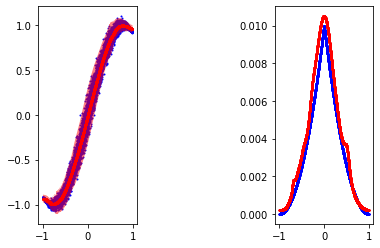

103 -2.5867096965319276


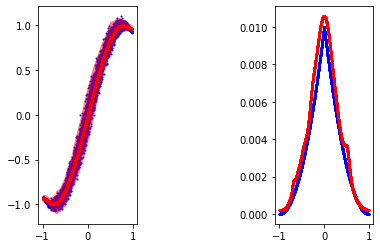

104 -2.587395554966667


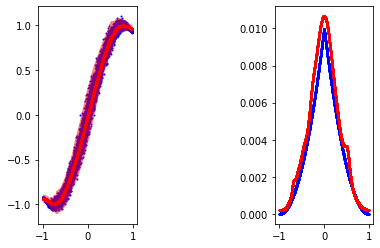

105 -2.5880658005801984


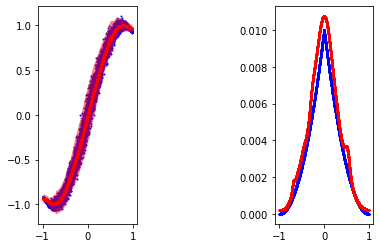

106 -2.588709209219686


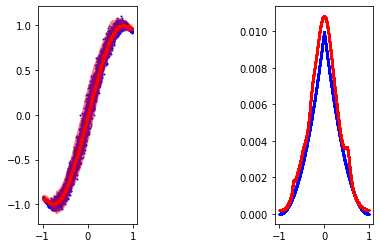

107 -2.589316671856778


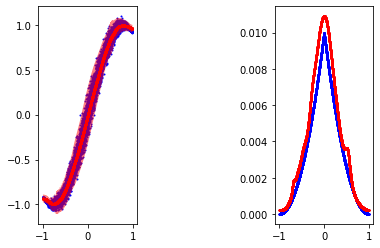

108 -2.58988436022973


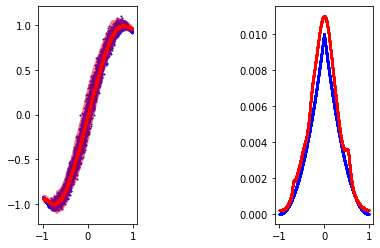

109 -2.590411913756504


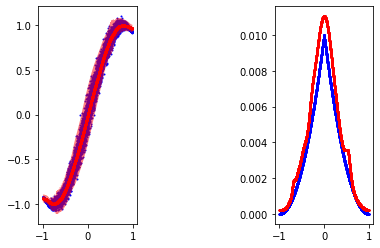

110 -2.590899034401572


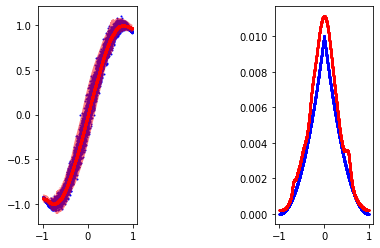

111 -2.5913447933136995


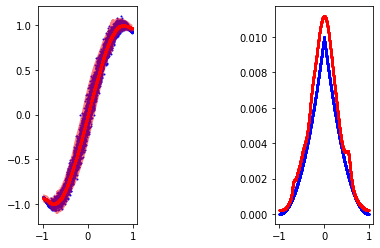

112 -2.5917492846703483


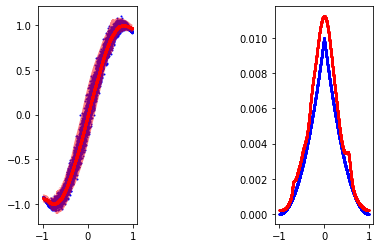

113 -2.5921144993737797


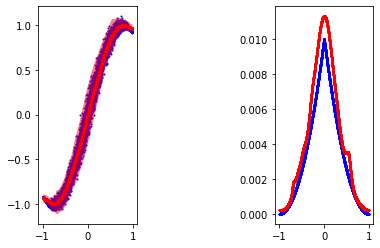

114 -2.5924441819428425


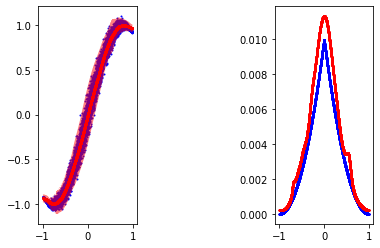

115 -2.5927437830734252


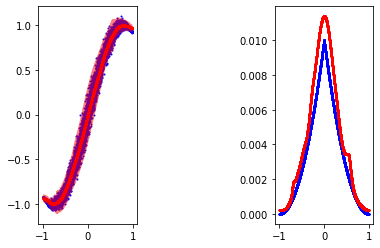

116 -2.593020086957482


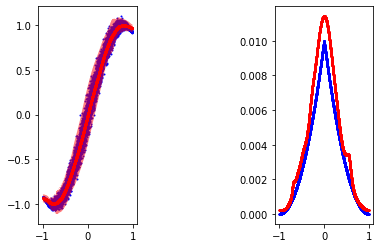

117 -2.5932800934709417


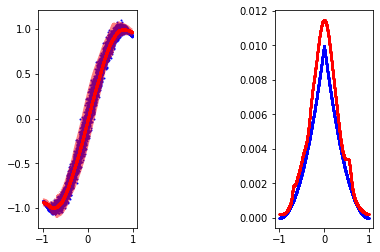

118 -2.5935298220029996


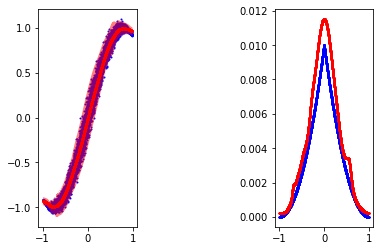

119 -2.593773625170901


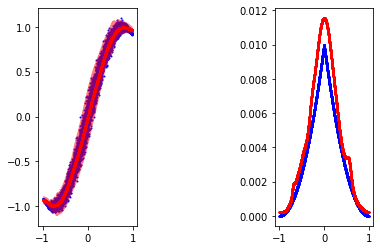

120 -2.594014082688601


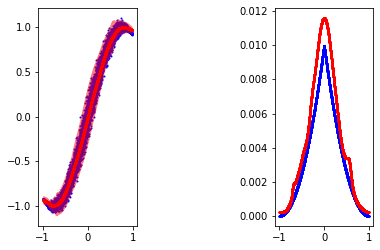

121 -2.594252296589201


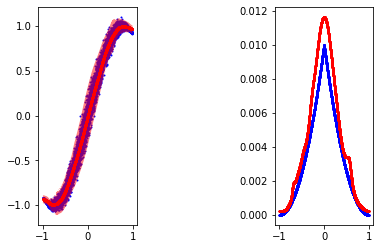

122 -2.594488363797643


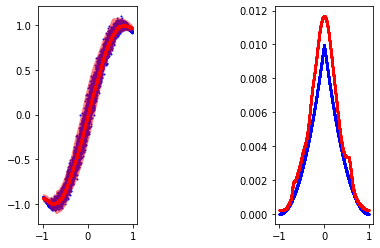

123 -2.5947218411613706


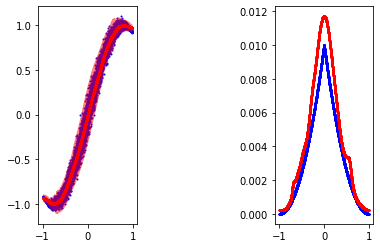

124 -2.5949520937829225


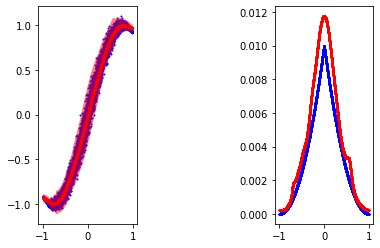

125 -2.595178496178002


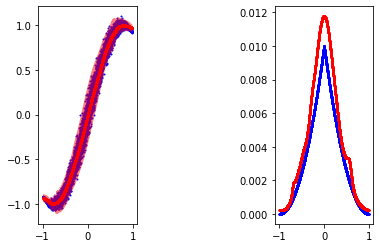

126 -2.5954005111751264


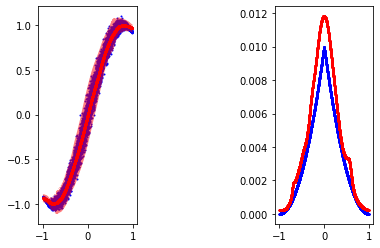

127 -2.595617695143952


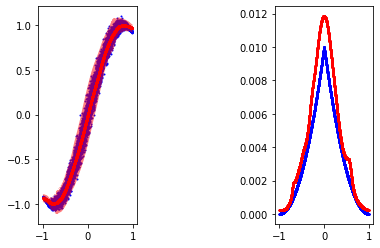

128 -2.595829677084774


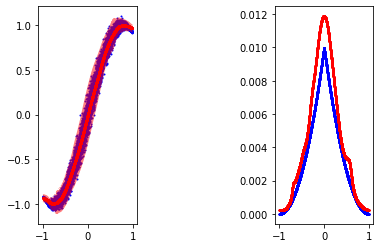

129 -2.59603614546364


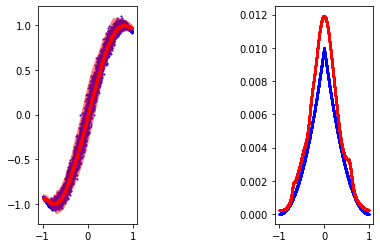

130 -2.5962368600355687


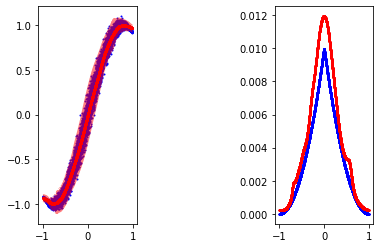

131 -2.5964316912593683


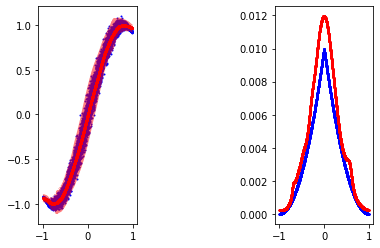

132 -2.5966206789264157


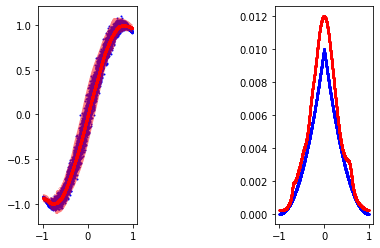

133 -2.5968040945380153


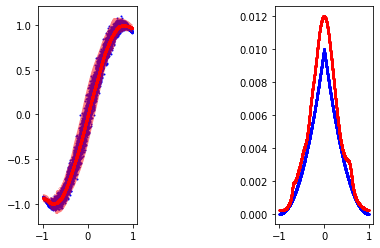

134 -2.5969824888577544


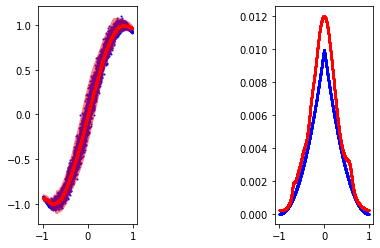

135 -2.597156707301698


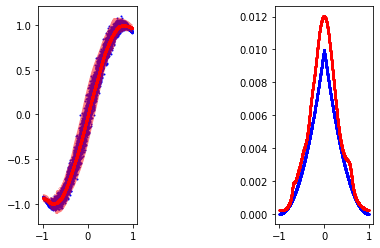

136 -2.5973278618937026


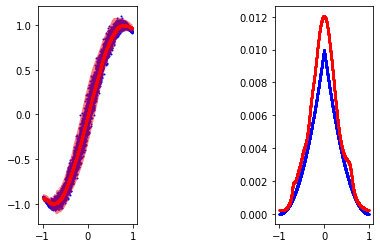

137 -2.5974972598624286


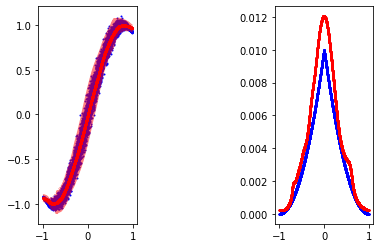

138 -2.5976663063796472


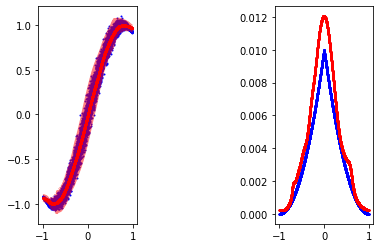

139 -2.5978364237557896


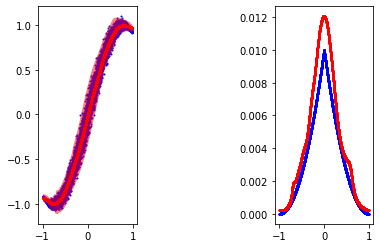

140 -2.5980090625305237


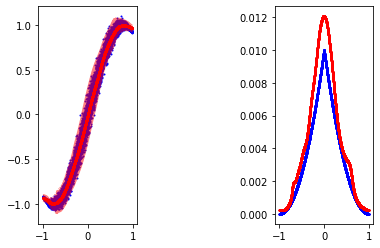

141 -2.598185922356604


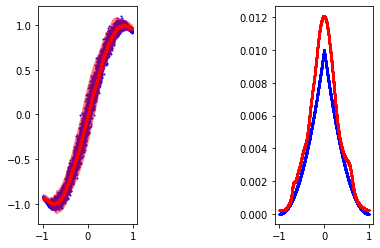

142 -2.598369562489893


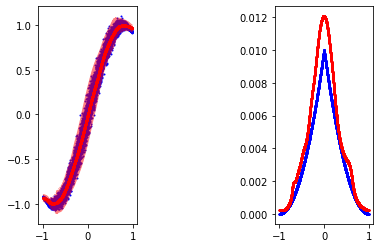

143 -2.5985647011230197


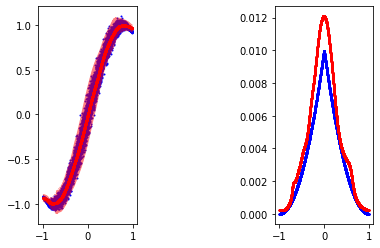

144 -2.598780772477499


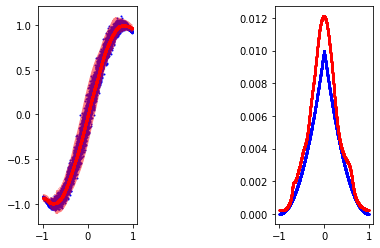

145 -2.5990369699902254


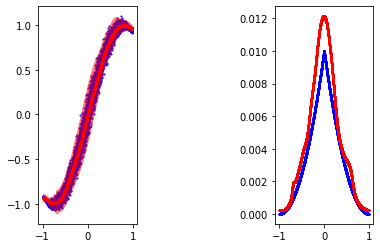

146 -2.5993728203482465


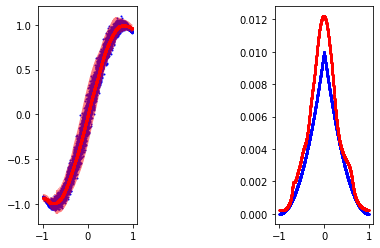

147 -2.5998727414647322


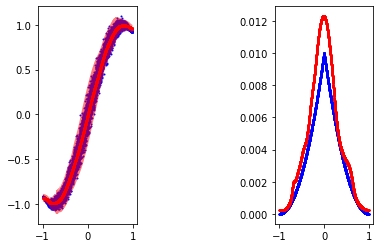

148 -2.6007289586640177


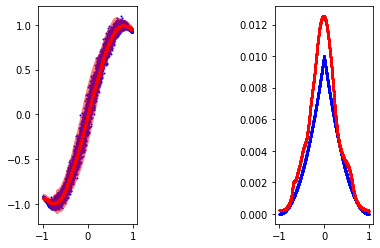

149 -2.602397106133704


In [9]:
#Train
optimizer = optim.Adam(net.parameters(), lr=1e-2)

N_epoch = 150

for epoch in range(N_epoch):
    loss_tracker = 0
    for i in range(X_train.shape[0]):
        optimizer.zero_grad()

        inp = X_train[i]
        target = y_train[i]

        output, _ = net(inp)
        pred = output[-1, :, 0]
        var = 1 + output[-1, :, 1]
        loss = gaussian_nll_loss(pred, target, var)
        loss.backward()
 
        loss_tracker += loss.item()
        optimizer.step()
    
    #print(epoch, loss_tracker)

    Preds = np.empty(shape=(X_ordered.shape[0], batch_size))
    Targets = y_ordered.reshape(1, -1)
    Vars = np.empty(shape=(X_ordered.shape[0], batch_size))

    for test in range(X_ordered.shape[0]):
      output, _ = net(torch.from_numpy(X_ordered[test]).to(device))
      pred = output[-1, :, 0].clone().detach().cpu().numpy()
      Preds[test] = pred
      var = 1 + output[-1, :, 1].clone().detach().cpu().numpy()
      Vars[test] = var

    Preds = Preds.reshape(1, -1).flatten()
    Vars = Vars.reshape(1, -1).flatten()
    X = np.mean(X_ordered, axis=1).reshape(1, -1).flatten()

    plt.subplot(131)
    plt.scatter(X, Targets, s = 1, color='blue')
    plt.scatter(X, Preds, s = 1, color = 'red')
    plt.fill_between(X, Preds - 3*np.sqrt(Vars), Preds + 3*np.sqrt(Vars), facecolor='red', alpha=0.5)
    plt.subplot(133)
    plt.scatter(X, variance, s=1, color='blue')
    plt.scatter(X, Vars, s=1, color='red')
    plt.show()

    print(epoch, loss_tracker/X_train.shape[0])